In [1]:
# INPUTS 
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

In [2]:
#import multiprocessing as mp
#mp.set_start_method("spawn", force=True)

import os
os.environ["HYDRA_FULL_ERROR"] = "1"

import hydra
with hydra.initialize('config', version_base='1.3'):
    cfg = hydra.compose("main", overrides=[
        'xp= unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_duacs_RonanUnet','+params=test_2018_jun'
    ])

mutivar_da,dic_inputs = hydra.utils.call(cfg.datamodule.multivar_da)

#dm = hydra.utils.call(cfg.datamodule) # will instantiate src.data.BaseDataModule with parameters specified in config
#dm.setup() # setup the datamodule see https://lightning.ai/docs/pytorch/stable/data/datamodule.html#lightningdatamodule-api*


/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


init open_multivar_datasets
RAM = 0.58 Go
{'lat': slice(-70, 70, None), 'lon': slice(-180, 180, None), 'time': slice('2018-06-01', '2018-07-01', None)}

handling [ssh] var
for var open_multivar_datasets
RAM = 0.58 Go
<xarray.DataArray 'ssh' (time: 31, lat: 560, lon: 1440)> Size: 100MB
[24998400 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 248B 2018-06-01 2018-06-02 ... 2018-07-01
  * lat      (lat) float32 2kB -69.99 -69.73 -69.48 -69.23 ... 69.47 69.72 69.97
  * lon      (lon) float32 6kB -180.0 -179.7 -179.5 -179.2 ... 179.4 179.7 179.9
Attributes:
    units:          m
    long_name:      Absolute dynamic topography
    standard_name:  sea_surface_height_above_geoid

handling [ugos] var
for var open_multivar_datasets
RAM = 0.70 Go
<xarray.DataArray 'ugos' (time: 31, lat: 560, lon: 1440)> Size: 100MB
[24998400 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 248B 2018-06-01 2018-06-02 ... 2018-07-01
  * lat      (lat) float32 2k

In [3]:
mutivar_da = mutivar_da.isel(time=0)

In [4]:
mutivar_da.sel(variable="ssh")

<xarray.DataArray (lat: 560, lon: 1440)> Size: 3MB
array([[        nan, -1.2674241 , -1.2656968 , ..., -1.2717065 ,
        -1.2707249 , -1.2695051 ],
       [        nan, -1.2623353 , -1.2610896 , ..., -1.2643225 ,
        -1.2639303 , -1.2634363 ],
       [        nan, -1.2533796 , -1.2526538 , ..., -1.2564615 ,
        -1.2558192 , -1.2545419 ],
       ...,
       [        nan, -0.17516753, -0.16990732, ..., -0.18643104,
        -0.18581556, -0.18278094],
       [        nan, -0.16721918, -0.16322222, ..., -0.18025607,
        -0.17897822, -0.17251796],
       [        nan, -0.16097291, -0.15908103, ..., -0.1703095 ,
        -0.16814269, -0.16486841]], dtype=float32)
Coordinates:
    time      datetime64[ns] 8B 2018-06-01
  * lat       (lat) float32 2kB -69.99 -69.73 -69.48 ... 69.47 69.72 69.97
  * lon       (lon) float32 6kB -180.0 -179.7 -179.5 ... 179.4 179.7 179.9
    variable  <U3 12B 'ssh'

In [16]:
list_var = list(dic_inputs.keys()) #.remove('latitude_var')
del list_var[-4], list_var[-3], list_var[2],list_var[3]
list_var


['ssh', 'ugos', 'u10', 'latitude_var', 'bathy']

In [ ]:
import torch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.50
plt.rcParams['font.size'] = '20.0'

# Initialisation des subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(20, 20),subplot_kw={'projection': ccrs.PlateCarree()})
#plt.subplots_adjust(hspace=0.5)  # Augmente l'espace vertical
# Aplatir la grille d'axes pour faciliter l'itération
axes = axes.ravel()
plt.subplots_adjust(hspace=0.3)  # Augmente l'espace vertical


list_var_str = ["ssh",'uv$_{geo}$','uv$_{wind}$','lat','bathy']

# Itérer sur chaque variable et tracer
for i, variable in enumerate(list_var):
    
    import cartopy
    # projection = cartopy.crs.Mercator()
    axes[i].add_feature(cartopy.feature.LAND, zorder=2)
    axes[i].add_feature(cartopy.feature.COASTLINE, zorder=2)
    axes[i].add_feature(cartopy.feature.LAKES, alpha=0.5, zorder=2)
    axes[i].add_feature(cartopy.feature.RIVERS, zorder=2)

    axes[i].coastlines(resolution='10m', lw=0.5)
    
    # Sélectionner la variable courante
    da_var = mutivar_da.sel(variable=variable).fillna(0)

    # Tracer avec pcolormesh
    if "gos" in variable:
        mesh = axes[i].pcolormesh(da_var.lon, da_var.lat, da_var, shading='auto',cmap=plt.cm.RdBu_r,vmin=-0.5,vmax=+0.5) 
    elif "ssh" in variable:
        mesh = axes[i].pcolormesh(da_var.lon, da_var.lat, da_var, shading='auto',cmap=plt.cm.RdBu_r,vmin=-1,vmax=+1) 
    elif "bathy" in variable:
        mesh = axes[i].pcolormesh(da_var.lon, da_var.lat, da_var, shading='auto',cmap=plt.cm.RdBu_r)
    else:
        mesh = axes[i].pcolormesh(da_var.lon, da_var.lat, da_var, shading='auto',cmap=plt.cm.RdBu_r)

    axes[i].text(0.02, 0.02, list_var_str[i], transform=axes[i].transAxes,
            fontsize=10, verticalalignment='bottom', horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    #axes[i].set_ylabel(list_var_str[i])

    # Supprimer les ticks des axes x et y
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    # Ajouter une barre de couleur
    #fig.colorbar(mesh, ax=axes[i], orientation='vertical', fraction=0.046, pad=0.04)

# Masquer les axes inutilisés si le nombre de variables est inférieur à 8
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

#plt.show()

# Save the figure with transparency
#plt.savefig('/Odyssey/private/t22picar/plot_article/figures/inputs.png', transparent=True, dpi=300, bbox_inches='tight')

In [65]:
# OUPUTS 
path_output = "/Odyssey/private/t22picar/multivar_drifter/rec/unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_duacs/daily/unet_rec_2019-06-01.nc"
res_data = xr.open_dataset(path_output)
res_data = res_data.rename({"ugos": "utot"})
res_data = res_data.rename({"vgos": "vtot"})
res_data
list_var=['utot','vtot']

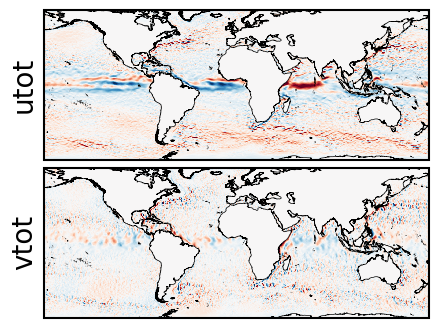

In [66]:
import torch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.50
plt.rcParams['font.size'] = '20.0'

# Initialisation des subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), constrained_layout=False,subplot_kw={'projection': ccrs.PlateCarree()})

plt.subplots_adjust(hspace=0.05)  # Augmente l'espace vertical
# Aplatir la grille d'axes pour faciliter l'itération
axes = axes.ravel()

# Itérer sur chaque variable et tracer
for i, variable in enumerate(list_var):
        
    axes[i].coastlines(resolution='10m', lw=0.5)

    # Sélectionner la variable courante
    da_var = res_data[variable].fillna(0)

    # Tracer avec pcolormesh
    mesh = axes[i].pcolormesh(da_var.lon, da_var.lat, da_var, shading='auto',cmap=plt.cm.RdBu_r,vmin=-1,vmax=+1)

    # Ajouter un titre
    if variable == "latitude_var":
        axes[i].set_title('lat')
    else: 
        axes[i].set_ylabel(f'{variable}',size=20)

    # Supprimer les ticks des axes x et y
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    # Ajouter une barre de couleur
    #fig.colorbar(mesh, ax=axes[i], orientation='vertical', fraction=0.046, pad=0.04)


# Masquer les axes inutilisés si le nombre de variables est inférieur à 8
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.savefig('/Odyssey/private/t22picar/plot_article/figures/output.png', transparent=True, dpi=300, bbox_inches='tight')

In [62]:
# TARGET 
import torch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [63]:
# OUPUTS 
path_output = "/Odyssey/private/t22picar/data/drifters/daily_uv/drifters_uv_aoml_15m_4th.nc"
res_data = xr.open_dataset(path_output).sel(time = slice("2019-05-25","2019-06-06")).mean(dim="time")
res_data
list_var=['u_drifter','v_drifter']

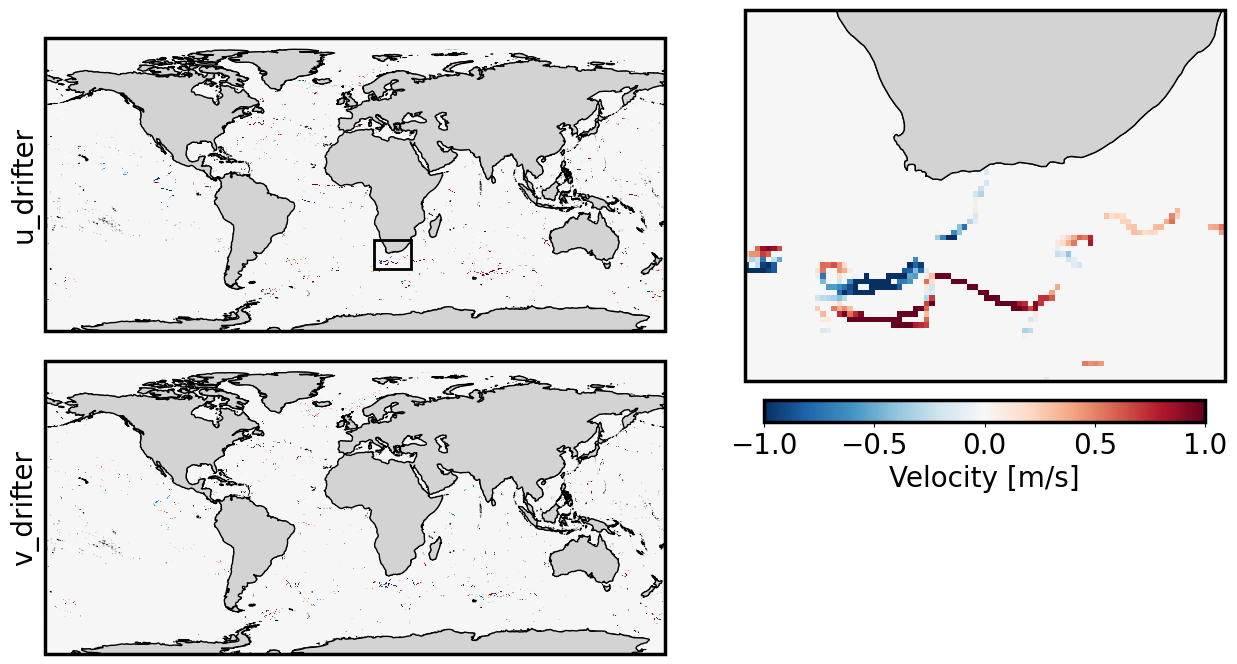

In [64]:

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50
#zoom_extent=[-80, -43, 25, 46.5 ]
zoom_extent = [11, 33, -44, -27] #Agulhas
zoom_ax = [1, 0.4, 0.6, 0.6]
# Initialisation des subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8), constrained_layout=False,subplot_kw={'projection': ccrs.PlateCarree()})


plt.subplots_adjust(hspace=0.1)  # Augmente l'espace vertical
# Aplatir la grille d'axes pour faciliter l'itération
axes = axes.ravel()

# Itérer sur chaque variable et tracer
for i, variable in enumerate(list_var):
    
    axes[i].add_feature(
    cfeature.LAND,
    facecolor='lightgray',  # Couleur de remplissage
    edgecolor='black',      # Couleur des bordures (optionnel)
    zorder=2                # Ordre de dessin (0 = en arrière-plan)
    )
        
    axes[i].coastlines(resolution='10m', lw=0.5)
    #axs.add_feature(cfeature.LAND.with_scale('50m'), facecolor='#EEEEEE', edgecolor='face',alpha=1)

    # Sélectionner la variable courante
    da_var = res_data[variable].fillna(0)

    # Tracer avec pcolormesh
    mesh = axes[i].pcolormesh(da_var.lon, da_var.lat, da_var, shading='auto',cmap=plt.cm.RdBu_r,vmin=-0.5,vmax=+0.5)

    # Ajouter un titre
    if variable == "latitude_var":
        axes[i].set_title('lat')
    else: 
        axes[i].set_ylabel(f'{variable}',size=20)

    # Supprimer les ticks des axes x et y
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    # Ajouter une barre de couleur
    #fig.colorbar(mesh, ax=axes[i], orientation='vertical', fraction=0.046, pad=0.04)

    if i==0:
        # Ajouter un zoom sur une région spécifique
        ax_zoom = fig.add_axes(zoom_ax, projection=ccrs.PlateCarree())
        ax_zoom.set_extent(zoom_extent, crs=ccrs.PlateCarree())  # Exemple de zoom sur l'Europe
        ax_zoom.coastlines()

        ax_zoom.add_feature(
            cfeature.LAND,
            facecolor='lightgray',  # Couleur de remplissage
            edgecolor='black',      # Couleur des bordures (optionnel)
            zorder=2                # Ordre de dessin (0 = en arrière-plan)
        )

        contour_zoom = ax_zoom.pcolormesh(da_var.lon, da_var.lat, da_var, cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree(),vmin=-1,vmax=+1)

        # Ajouter les contours de la zone zoomée sur la carte principale
        zoom_rect = plt.Rectangle((zoom_extent[0], zoom_extent[2]),
                                zoom_extent[1] - zoom_extent[0],
                                zoom_extent[3] - zoom_extent[2],
                                linewidth=2, edgecolor='k', facecolor='none',
                                transform=ccrs.PlateCarree(),zorder=10)
        axes[i].add_patch(zoom_rect)

        # Ajouter une barre de couleur
        cb = fig.colorbar(contour_zoom, ax=ax_zoom, orientation='horizontal', fraction=0.046, pad=0.04)
        cb.set_label('Velocity [m/s]')
        





# Masquer les axes inutilisés si le nombre de variables est inférieur à 8
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.savefig('/Odyssey/private/t22picar/plot_article/figures/target.png', transparent=True, dpi=300, bbox_inches='tight')